In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from src.input import Input_uc
from src.output import Output_uc
from src.unit_commitment import solve_uc_formulation_0, solve_uc_formulation_1

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
num_units = 122
num_periods = 24
time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")

In [3]:
path_folder_processed = Path.cwd() / "data" / "input" / "processed"
timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]
idx_time_prev = idx_time_start - 1
if idx_time_prev < 0:
    raise NotImplementedError("not 2022-01-01T00 for the time start")

In [4]:
unit_type = np.load(path_folder_processed / "unit_type.npy")
idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
idx_coal = np.load(path_folder_processed / "idx_coal.npy")
idx_lng = np.load(path_folder_processed / "idx_lng.npy")
p_min = np.load(path_folder_processed / "p_min.npy")
p_max = np.load(path_folder_processed / "p_max.npy")
ramp_up = np.load(path_folder_processed / "ramp_up.npy")
ramp_down = np.load(path_folder_processed / "ramp_down.npy")
startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
min_up = np.load(path_folder_processed / "min_up.npy")
min_down = np.load(path_folder_processed / "min_down.npy")
cost_lin = np.load(path_folder_processed / "cost_lin.npy")
cost_const = np.load(path_folder_processed / "cost_const.npy")

In [5]:
cost_startup_step_formulation_0 = pickle.load(open(path_folder_processed / "cost_startup_step_formulation_0.pkl", "rb"))
num_cooling_steps_formulation_0 = np.load(path_folder_processed / "num_cooling_steps_formulation_0.npy")
cost_startup_step_formulation_1 = np.load(path_folder_processed / "cost_startup_step_formulation_1.npy")
step_length_formulation_1 = np.load(path_folder_processed / "step_length_formulation_1.npy")

In [6]:
demand_2022 = np.load(path_folder_processed / "demand_2022.npy")
demand = demand_2022[idx_time_start:idx_time_end+1]

In [7]:
# mustoff_2022 = np.load(path_folder_processed / "mustoff_2022.npy")

In [8]:
renewable_2022 = np.load(path_folder_processed / "renewable_2022.npy")
renewable = renewable_2022[idx_time_start:idx_time_end+1]

In [9]:
status_2022 = np.load(path_folder_processed / "status_2022.npy")
u_prev = status_2022[:, idx_time_start-num_cooling_steps_formulation_0.max():idx_time_start]

In [10]:
# for TA marking: you can check like this easily for init condition correctness
# for idx_unit, (u_prev_i, min_up_i) in enumerate(zip(u_prev, min_up)):
#     summm = sum(u_prev_i[-min_up_i:])
#     if summm not in (0, min_up_i):
#         print(idx_unit, u_prev_i[-min_up_i:])

# for idx_unit, (u_prev_i, min_down_i) in enumerate(zip(u_prev, min_down)):
#     summm = sum(u_prev_i[-min_down_i:])
#     if summm not in (0, min_down_i):
#         print(idx_unit, u_prev_i[-min_down_i:])

def _tail_count(seq, value):
    cnt = 0
    for x in reversed(seq):
        if x == value:
            cnt += 1
        else:
            break
    return cnt

min_up_r, min_down_r = [], []
for hist, mu, md in zip(u_prev, min_up, min_down):
    on_tail  = _tail_count(hist, 1)
    off_tail = _tail_count(hist, 0)

    if on_tail:
        min_up_r.append(max(0, mu - on_tail))
        min_down_r.append(0)
    else:
        min_up_r.append(0)
        min_down_r.append(max(0, md - off_tail))

min_up_r, min_down_r = np.array(min_up_r).astype(np.int64), np.array(min_down_r).astype(np.int64)

In [11]:
def _tail_count(seq, value):
    cnt = 0
    for x in reversed(seq):
        if x == value:
            cnt += 1
        else:
            break
    return cnt

min_up_0 = np.array(
    [_tail_count(u_prev[g], 1) for g in range(num_units)], dtype=np.int64
)
min_down_0 = np.array(
    [_tail_count(u_prev[g], 0) for g in range(num_units)], dtype=np.int64
)

---
---
---

In [12]:
idx_u_prev_up = u_prev[:, -1].astype(bool)
p_prev = np.zeros(num_units)
p_prev[idx_u_prev_up] = p_min[idx_u_prev_up]

In [ ]:
input_uc = Input_uc(
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    #########################
    demand=demand,
    reserve=(demand - renewable) * 0.1,
    renewable=renewable,
    #########################
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    #########################
    cost_lin=cost_lin,
    cost_const=cost_const,
    #########################
    cost_startup_step_formulation_0=cost_startup_step_formulation_0,
    num_cooling_steps_formulation_0=num_cooling_steps_formulation_0,
    cost_startup_step_formulation_1=cost_startup_step_formulation_1,
    step_length_formulation_1=step_length_formulation_1,
    #########################
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

---
---
---

In [14]:
# output_uc = Output_uc()
# solve_uc_formulation_0(input_uc=input_uc, output_uc=output_uc, verbose=True)

In [ ]:
output_uc = Output_uc()
solve_uc_formulation_1(input_uc=input_uc, output_uc=output_uc, verbose=True)

Set parameter OutputFlag to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Start tuning.
Tune 33 parameters.

Solving model using baseline parameter set with TimeLimit=3600s

-------------------------------------------------------------------------------

Testing candidate parameter set 1...

	Default parameters

Solving model_000 with random seed #1 ... MIP gap 0.01%
Solving model_000 with random seed #2 ... MIP gap 0.01%
Solving model_000 with random seed #3 ... MIP gap 0.01%

Summary candidate parameter set 1 
 # Name              0        1        2      Avg  Std Dev      Max
 0              34.85s   11.57s   10.82s   19.08s    11.16   34.85s

Setting total tuning time limit to 572s
(set the TuneTimeLimit parameter to choose a different value)

-------------------------------------------------------------------------------
B

In [ ]:
with open("compare.pkl", "rb") as f:
    compare = pickle.load(f)
# with open("compare.pkl", "wb") as f:
#     pickle.dump(output_uc, f)
objval = compare.total_cost - compare.total_cost_reserve

In [ ]:
# with open("reserve_10.pkl", "rb") as f:
#     compare = pickle.load(f)
# # with open("reserve_10.pkl", "wb") as f:
# #     pickle.dump(output_uc, f)
# objval = compare.total_cost - compare.total_cost_reserve

In [ ]:
# with open("reserve_20.pkl", "rb") as f:
#     compare = pickle.load(f)
# # with open("reserve_20.pkl", "wb") as f:
# #     pickle.dump(output_uc, f)
# objval = compare.total_cost - compare.total_cost_reserve

In [ ]:
25884345357.884823 - (output_uc.total_cost - output_uc.total_cost_reserve)

0.0

29 s without proj

In [ ]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
def plot_heatmap(input_uc: Input_uc, output_uc: Output_uc, fig_height: float = 20, pad_rectangle: float = None):
    cmap = plt.cm.jet.copy()
    cmap.set_bad(color="white")
    num_periods = output_uc.p.shape[1]

    idx_marginal_unit_per_period = np.array([
        int(np.where(input_uc.cost_lin == mpg)[0][0]) 
        if mpg > 0 else -2 # for test (demand = 0 to blackstart) result plot purpose
        for mpg in output_uc.marginal_price_generation
        ])

    helper = [
        (input_uc.idx_lng, len(input_uc.idx_nuclear) + len(input_uc.idx_coal)),
        (input_uc.idx_coal, len(input_uc.idx_nuclear)),
        (input_uc.idx_nuclear, 0),
    ]

    fig, axes = plt.subplots(3, 1, figsize=(fig_height, fig_height), gridspec_kw={"height_ratios": [56/122, 41/122, 25/122]}, sharex=True)

    for ax, (idx_type, idx_start) in zip(axes, helper):
        p_type = output_uc.p[idx_type]
        num_units_type = len(p_type)
        p_min_type = np.tile(input_uc.p_min[idx_type][:, None], reps=num_periods)
        p_max_type = np.tile(input_uc.p_max[idx_type][:, None], reps=num_periods)
        heatmap = (p_type - p_min_type) / (p_max_type - p_min_type) * 100
        heatmap[p_type == 0] = np.nan

        #
        ax.imshow(
            heatmap,
            aspect="auto",
            origin="lower",
            extent=[0.5, 24 + 0.5, idx_start, idx_start + num_units_type],
            cmap=cmap,
            vmin=0,
            vmax=100,
        )
        
        #
        pad_rectangle = 0.066 / 20 * fig_height if pad_rectangle is None else pad_rectangle
        for t in range(num_periods):
            u_abs = idx_marginal_unit_per_period[t]
            if idx_start <= u_abs < idx_start + num_units_type:

                rect_h = Rectangle(
                    (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
                    fill=False,
                    edgecolor="white",
                    facecolor="none",
                    hatch="///",
                    linewidth=0,
                    zorder=3
                )
                rect_h.set_hatch_linewidth(fig_height / 10)
                ax.add_patch(rect_h)

                ax.add_patch(
                    Rectangle(
                        (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
                        fill=False,
                        edgecolor="black",
                        facecolor="none",
                        # hatch="//",
                        linewidth=fig_height / 5,
                        zorder=3
                    )
                )

        #
        ax.set_yticks([idx_start, idx_start + num_units_type - 1])
        ax.set_yticklabels([idx_start + 1, idx_start + num_units_type])
        ax.tick_params(axis="both", width=fig_height / 10, length=fig_height / 2, pad=fig_height / 2, labelsize=fig_height * 2)
        for side in ["bottom", "left", "top", "right"]:
            ax.spines[side].set_linewidth(fig_height / 10)

    if num_periods == 24:
        axes[-1].set_xticks([1, 6, 12, 18, 24])
        axes[-1].set_xticklabels([1, 6, 12, 18, 24])

    # axes[-2].hlines(y=57, xmin=1, xmax=24, colors="black", ls="--") # for TA: you can test like this the 57th (0-based) idx unit will be shown

    plt.tight_layout()
    plt.show(fig)

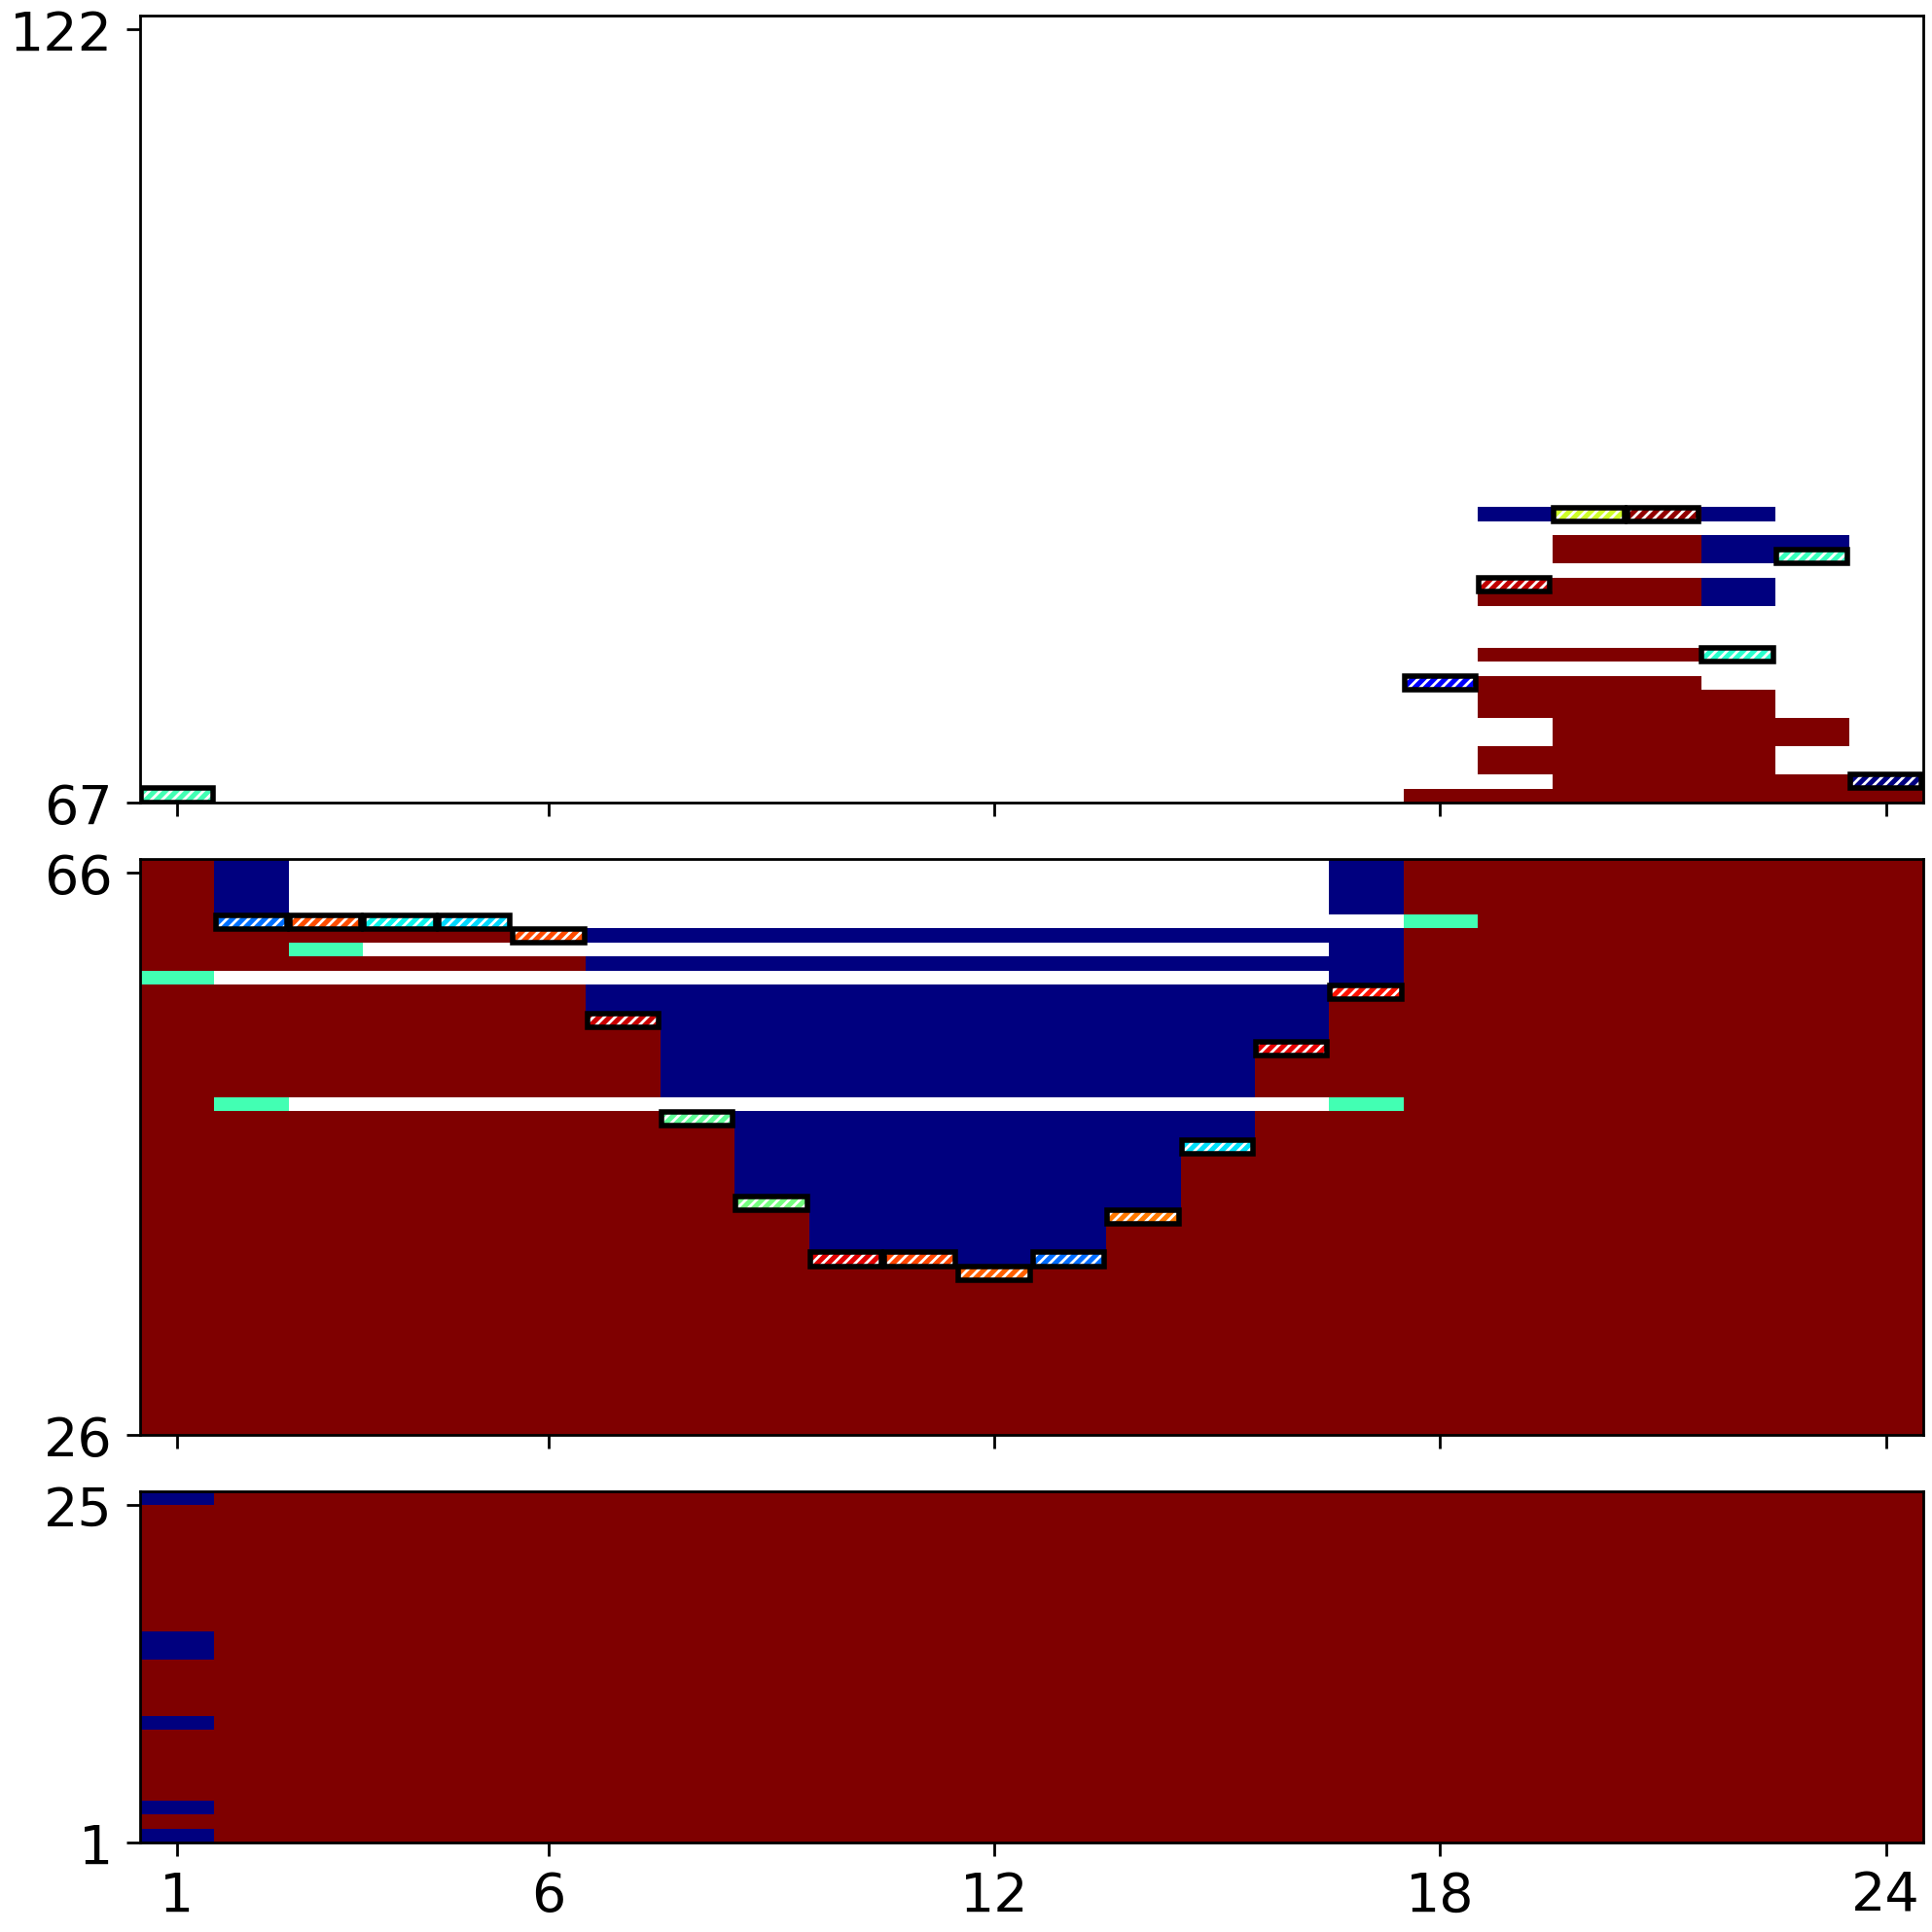

In [ ]:
# plot_heatmap(input_uc=input_uc, output_uc=output_uc, fig_height=20, pad_rectangle=0.03)
plot_heatmap(input_uc=input_uc, output_uc=output_uc, fig_height=20, pad_rectangle=0.02)